#**Graded Challenge 3**
## **C2C e-commerce Business Plan: "The Look" to Gain Profits based on Number of Users**

Nadia Oktiarsy, FSDS Batch-016 RMT (Buddy: Hana)

---
```
Table of Contents:
1. Objective
2. Problem Statement
3. Goals and Solution
4. Data Preparation
   4.1. Importing Libraries
   4.2. Reviewing Data in 2022
        - Transaction Status
        - Total Revenue
        - Number of Users
        - Quantity of Item Purchased
        - Frequently Purchased Products (Quantity)
        - The Highest Revenue of Frequently Purchased Products
5. Business Analysis
   5.1. Correlation Analysis
   5.2. Gross Mechandise Value (GMV)
   5.3. Business Goal: The Evaluation
6. Conclusion
```

---
## **1. Background**

The Look is one of the biggest e-commrece Consumer-to-Consumer (C2C), platform on Mars, and currently trying to improve the company business. The evaluation is needed especially to understand the future plan that will be taken for the company, by **understanding to increase number of users for this platform**. Number of users will be important to gain profits, especially to gain new investors, so that The Look can keep improving the business to other sectors.

To improve the company business plan, a data scientist is assigned to state the problems first, and then propose the success criterias based on SMART, which is the abbreviation of **S**pecific, **M**easurable, **A**ction-oriented, **R**elevant, and **T**ime-bound.

From here, the Look e-commerce business evaluation and plan will be taken by data analysis through SQL.

---
## **2. Problem Statements**

The problem will be raised based on the data available at first, which means the approach to state the problem and set the goal is **a bottom-up** one. The steps that will be taken are:

1. Identifying data \
Several things before stating problems is by understanding and identifying the available data. The source of data itself is from `bigquery-public-data` specifically from `thelook_ecommerce`, with table Users (`users`), Order (`orders`), Products (`products`) and Products Purchased (`inventory_items`) on Google Cloud. The query's month will be reviewed dan divided quarterly in 2022, indicated by:
  - Q1 (January-March)
  - Q2 (April-June)
  - Q3 (July-September)
  - Q4 (October-December)
  
  The data will also be reviewed into three important variables (Q1~Q3): 
  - Numbe of Users
  - Products (`number of transactions`, `number of item purchased`, and `frequently purchased products`)
  - Price (`cost`, and `retail price`)

2. Problem statements based on identifying data \
Problems statements is to craft the effective questions from data.  If the business plan is **to gain more profits based on the number of users in the end of quarter of 2022**, then the main question will be: "*Which one is the most correlated factors with the increase number of users: Products or Price?*" By using SMART criteria success, we define as:

  - **Specific**: How many transaction status with complete transactions?
  - **Measurable**: What are top purchased products based on frequently purchased and the highest revenue purchased products?
  - **Action-oriented**: What features that need improvement and would make the database of transaction status is more accurate?
  - **Relevant**: How much would users pay to purchase products? 
  - **Time-bound**: Has The Look become more or less popular in the last three quarter of 2022 (Q1~Q3)?

3. Hypothesis for problem statements \
Hypothesis that will be tested is through correlation analysis, with the value of *R-Squared* is always between 0 to 1 (0% to 100%). The correlation will be taken into two kinds, which both of them must be `Complete` transaction status:
  - Correlation between `Number of Users` and `Transaction Status`
  - Correlation between `Number of Users` and `Total Revenue`
  - Between `Transaction Status` and `Total Revenue`, **high correlation** value (*R-squared*) should be `1` and `almost 1`, **low correlation** value should be `almost 0`, and **no correlation** value is `0`.

---
## **3. Goals and Solution**

This part will be further explain on part `5. Data Analysis`. As the summary of the goals that should be fulfilled:
1. The data described and explain on part `4. Data Preparation` should answer the main question and SMART criteria on Problem Statements.
2. To evaluate if the analysis from Q1~Q3 can predict the beginning of Q4 (October), at which the target is $250,000, is realistic.
3. To consider whether The Look should get new investors or not during Q4 period (October-December 2022) based on the business health, calculated by Gross Merchandise Value (GMV).

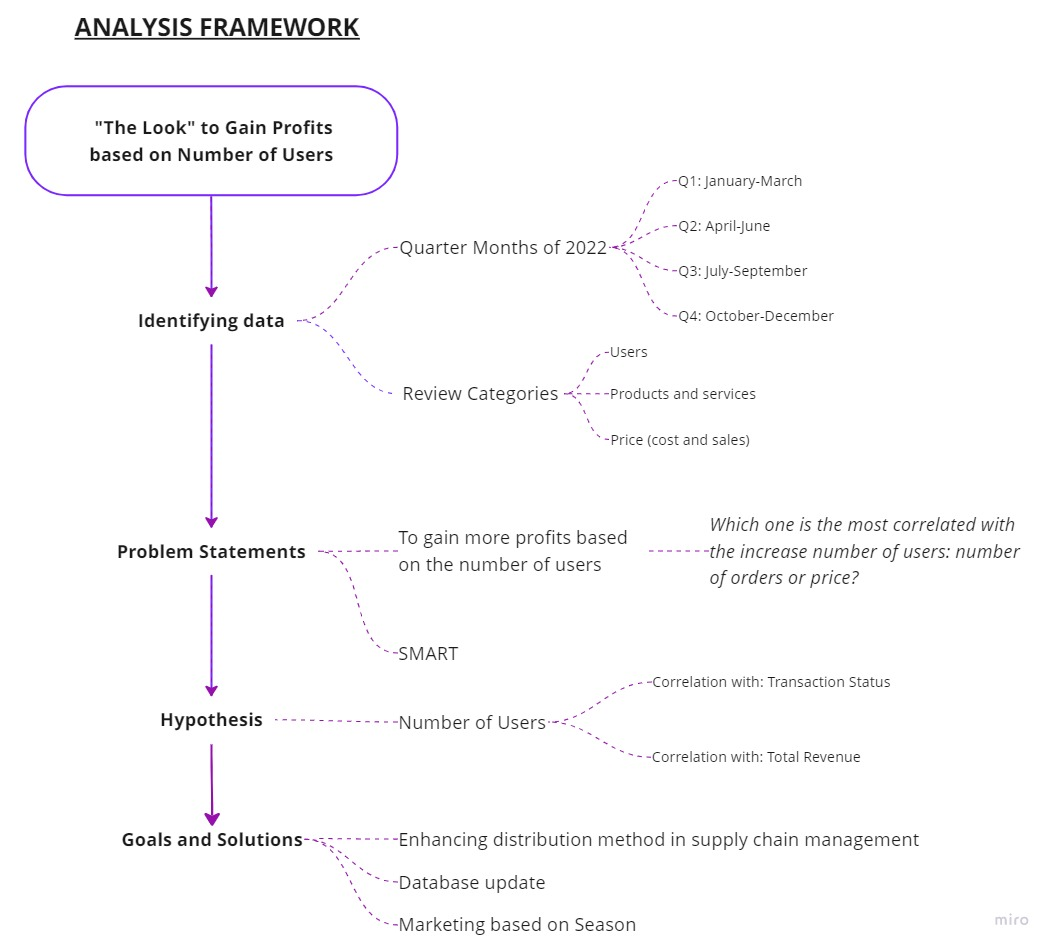

---
## **4. Data Preparation**

### **4.1. Importing Libraries**

In [ ]:
# Importing libraries
from google.cloud import bigquery
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import sys
import matplotlib
matplotlib.use('Agg')
%matplotlib inline

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
# Loading Project from Bigquery
project_id = "hacktiv8-016-nadiaoktiarsy"
client = bigquery.Client(project=project_id)

### **4.2. Reviewing Data in 2022**

#### **Transaction Status**

**Overview**

The patterns of status, both all status and status completed, are increasing from Q1 to Q3. For all status tables, we can see there is a slight decrease in February around `200 transactions` from January. After that, it jumps to `800 transactions` to `4,992 transactions` in March. Tables below explain about the comparison between transactions with all status (including Shipped, Cancelled, Processing, Returned) and status Complete.

In [ ]:
# Query 2022 comparison between transaction status complete and all status
transaction_status = client.query('''
SELECT DISTINCT
  EXTRACT(year FROM created_at) AS year,
  EXTRACT(month FROM created_at) AS month,
  COUNT(order_id) AS sales_all_status,
  COUNT(CASE WHEN status='Complete' THEN order_id ELSE NULL END) AS status_complete
FROM bigquery-public-data.thelook_ecommerce.orders
WHERE created_at BETWEEN "2022-01-01" AND "2023-01-01" 
GROUP BY year,month
ORDER BY year,month ASC;
''').to_dataframe()

transaction_status

,year,month,sales_all_status,status_complete
0,2022,1,4315,1099
1,2022,2,4242,1069
2,2022,3,5068,1294
3,2022,4,5167,1327
4,2022,5,5858,1453
5,2022,6,6327,1599
6,2022,7,7234,1765
7,2022,8,8168,2069
8,2022,9,9609,2408
9,2022,10,12671,3152


**Transaction Status Q1~Q3**

In [ ]:
# Q1, January-March 2022 with all status description
status_q1 = client.query('''
SELECT
  EXTRACT(year FROM created_at) AS year,
  EXTRACT(month FROM created_at) AS month,
  COUNT(order_id) AS status_all,
  COUNT(CASE WHEN status="Complete" THEN order_id ELSE NULL END) AS complete,
  COUNT(CASE WHEN status="Cancelled" THEN order_id ELSE NULL END) AS cancelled,
  COUNT(CASE WHEN status="Processing" THEN order_id ELSE NULL END) AS processing,
  COUNT(CASE WHEN status="Shipped" THEN order_id ELSE NULL END) AS shipped,
  COUNT(CASE WHEN status="Returned" THEN order_id ELSE NULL END) AS returned,
FROM `bigquery-public-data.thelook_ecommerce.orders`
WHERE created_at BETWEEN "2022-01-01" AND "2022-03-30" 
GROUP BY year,month
ORDER BY year,month ASC
''').to_dataframe()

status_q1

,year,month,status_all,complete,cancelled,processing,shipped,returned
0,2022,1,4315,1099,657,838,1278,443
1,2022,2,4242,1069,598,852,1275,448
2,2022,3,4732,1199,715,966,1410,442


In [ ]:
# Q2, April-June 2022 with all status description
status_q2 = client.query('''
SELECT
  EXTRACT(year FROM created_at) AS year,
  EXTRACT(month FROM created_at) AS month,
  COUNT(order_id) AS status_all,
  COUNT(CASE WHEN status="Complete" THEN order_id ELSE NULL END) AS complete,
  COUNT(CASE WHEN status="Cancelled" THEN order_id ELSE NULL END) AS cancelled,
  COUNT(CASE WHEN status="Processing" THEN order_id ELSE NULL END) AS processing,
  COUNT(CASE WHEN status="Shipped" THEN order_id ELSE NULL END) AS shipped,
  COUNT(CASE WHEN status="Returned" THEN order_id ELSE NULL END) AS returned,
FROM `bigquery-public-data.thelook_ecommerce.orders`
WHERE created_at BETWEEN "2022-04-01" AND "2022-06-30" 
GROUP BY year,month
ORDER BY year,month ASC
''').to_dataframe()

status_q2

,year,month,status_all,complete,cancelled,processing,shipped,returned
0,2022,4,5167,1327,759,1040,1522,519
1,2022,5,5858,1453,884,1165,1780,576
2,2022,6,6112,1538,955,1232,1778,609


In [ ]:
# Q2, July-September 2022 with all status description
status_q3 = client.query('''
SELECT
  EXTRACT(year FROM created_at) AS year,
  EXTRACT(month FROM created_at) AS month,
  COUNT(order_id) AS status_all,
  COUNT(CASE WHEN status="Complete" THEN order_id ELSE NULL END) AS complete,
  COUNT(CASE WHEN status="Cancelled" THEN order_id ELSE NULL END) AS cancelled,
  COUNT(CASE WHEN status="Processing" THEN order_id ELSE NULL END) AS processing,
  COUNT(CASE WHEN status="Shipped" THEN order_id ELSE NULL END) AS shipped,
  COUNT(CASE WHEN status="Returned" THEN order_id ELSE NULL END) AS returned,
FROM `bigquery-public-data.thelook_ecommerce.orders`
WHERE created_at BETWEEN "2022-07-01" AND "2022-09-30" 
GROUP BY year,month
ORDER BY year,month ASC
''').to_dataframe()

status_q3

,year,month,status_all,complete,cancelled,processing,shipped,returned
0,2022,7,7234,1765,1077,1413,2271,708
1,2022,8,8168,2069,1280,1581,2472,766
2,2022,9,9272,2314,1330,1950,2747,931


#### **Total Revenue**

**Overview**

According to the data, `cost` is the amount of money that sellers must spend for production. Meanwhile, `revenue` or `sales` is total amount of income generated by the sale of goods and services related to the primary operations of the business.
- First table below shows the expense (cost) and income target (price) that are set to gain the profit as much as possible during that month.
- The last table below shows the realization of selling with complete transaction. It is compared between the sum of cost and revenue.

In [ ]:
# The comparison between cost for production and the ideal price for sales in inventory or storage
inventory_items = client.query('''
SELECT DISTINCT
  EXTRACT(year FROM created_at) AS year,
  EXTRACT(month FROM created_at) AS month,
  SUM(ROUND(cost, 2)) AS cost,
  SUM(ROUND(product_retail_price, 2)) AS price,
FROM `bigquery-public-data.thelook_ecommerce.inventory_items`
WHERE created_at BETWEEN "2022-01-01" AND "2023-01-01"
GROUP BY year,month
ORDER BY year,month ASC;
''').to_dataframe() 

inventory_items

,year,month,cost,price
0,2022,1,466259.63,970243.98
1,2022,2,420400.58,876239.03
2,2022,3,489481.33,1015967.67
3,2022,4,504164.88,1049776.75
4,2022,5,531287.81,1106983.08
5,2022,6,539149.86,1122512.19
6,2022,7,605650.63,1258336.47
7,2022,8,693017.47,1445240.03
8,2022,9,623862.96,1297899.39
9,2022,10,315599.79,657551.38


In [ ]:
# Total Revenue of Q1 with status Complete
revenue_q1 = client.query('''

        SELECT
          status, year, month,
          SUM(cost_Q1) AS sum_cost_Q1,
          SUM(revenue_Q1) AS sum_revenue_Q1,
        FROM
          (SELECT DISTINCT
            status,
            extract(year from i.created_at) as year,
            extract(month from i.created_at) as month,
            ROUND(ii.cost, 2) as cost_Q1,
            ROUND(i.sale_price, 2) as revenue_Q1,
          FROM `bigquery-public-data.thelook_ecommerce.order_items` as i
          JOIN `bigquery-public-data.thelook_ecommerce.inventory_items` as ii
          ON i.product_id = ii.product_id
          WHERE i.status = 'Complete' and
                i.created_at between "2022-01-01" and "2022-03-31")
        GROUP BY year, month, status
        ORDER BY year, month ASC

''').to_dataframe()

revenue_q1

,status,year,month,sum_cost_Q1,sum_revenue_Q1
0,Complete,2022,1,42484.04,88610.34
1,Complete,2022,2,44284.92,93095.27
2,Complete,2022,3,49416.64,102962.36


In [ ]:
# Total Revenue of Q2 with status Complete
revenue_q2 = client.query('''

        SELECT
          status, year, month,
          SUM(cost_Q1) AS sum_cost_Q2,
          SUM(revenue_Q1) AS sum_revenue_Q2,
        FROM
          (SELECT DISTINCT
            status,
            extract(year from i.created_at) as year,
            extract(month from i.created_at) as month,
            ROUND(ii.cost, 2) as cost_Q1,
            ROUND(i.sale_price, 2) as revenue_Q1,
          FROM `bigquery-public-data.thelook_ecommerce.order_items` as i
          JOIN `bigquery-public-data.thelook_ecommerce.inventory_items` as ii
          ON i.product_id = ii.product_id
          WHERE i.status = 'Complete' and
                i.created_at between "2022-04-01" and "2022-06-30")
        GROUP BY year, month, status
        ORDER BY year, month ASC

''').to_dataframe()
revenue_q2

,status,year,month,sum_cost_Q2,sum_revenue_Q2
0,Complete,2022,4,55329.08,115331.18
1,Complete,2022,5,56599.74,117544.55
2,Complete,2022,6,60084.40,125151.71


In [ ]:
# Total Revenue of Q3 with status Complete
revenue_q3 = client.query('''

        SELECT
          status, year, month,
          SUM(cost_Q1) AS sum_cost_Q2,
          SUM(revenue_Q1) AS sum_revenue_Q2,
        FROM
          (SELECT DISTINCT
            status,
            extract(year from i.created_at) as year,
            extract(month from i.created_at) as month,
            ROUND(ii.cost, 2) as cost_Q1,
            ROUND(i.sale_price, 2) as revenue_Q1,
          FROM `bigquery-public-data.thelook_ecommerce.order_items` as i
          JOIN `bigquery-public-data.thelook_ecommerce.inventory_items` as ii
          ON i.product_id = ii.product_id
          WHERE i.status = 'Complete' and
                i.created_at between "2022-07-01" and "2022-09-30")
        GROUP BY year, month, status
        ORDER BY year, month ASC

''').to_dataframe()
revenue_q3

,status,year,month,sum_cost_Q2,sum_revenue_Q2
0,Complete,2022,7,69037.10,144483.93
1,Complete,2022,8,78128.42,162193.73
2,Complete,2022,9,90149.99,188257.35


In [ ]:
# Total Revenue of Q1~Q3 with status Complete
revenue_all = client.query('''

        SELECT
          status, year, month,
          SUM(cost_complete) AS sum_cost_complete,
          SUM(revenue_complete) AS sum_revenue_complete,
        FROM
          (SELECT DISTINCT
            status,
            extract(year from i.created_at) as year,
            extract(month from i.created_at) as month,
            ROUND(ii.cost, 2) as cost_complete,
            ROUND(i.sale_price, 2) as revenue_complete,
          FROM `bigquery-public-data.thelook_ecommerce.order_items` as i
          JOIN `bigquery-public-data.thelook_ecommerce.inventory_items` as ii
          ON i.product_id = ii.product_id
          WHERE i.status = 'Complete' and
                i.created_at between "2022-01-01" and "2023-01-01")
        GROUP BY year, month, status
        ORDER BY year, month ASC

''').to_dataframe()
revenue_all

,status,year,month,sum_cost_complete,sum_revenue_complete
0,Complete,2022,1,42484.04,88610.34
1,Complete,2022,2,44284.92,93095.27
2,Complete,2022,3,51207.02,106587.22
3,Complete,2022,4,55329.08,115331.18
4,Complete,2022,5,56599.74,117544.55
5,Complete,2022,6,62288.02,129754.05
6,Complete,2022,7,69037.10,144483.93
7,Complete,2022,8,78128.42,162193.73
8,Complete,2022,9,93471.96,195195.42
9,Complete,2022,10,120573.63,251007.87


#### **Number of Users**

To see how many users that are still active or subscribing the e-commerce. This table can also find the Churn Rate, the rate at which customers stop doing business with a company over a given period of time. However, from this observation, apparently there is no Churn Rate happening from January to September 2022 since the number of users keeps increasing.

In [ ]:
# from table inventory_items and order_items
num_of_users = client.query('''

SELECT
  EXTRACT(year FROM created_at) AS year,
  EXTRACT(month FROM created_at) AS month,
  COUNT(DISTINCT user_id) AS users_all,
  COUNT(DISTINCT CASE WHEN status = "Complete" THEN user_id ELSE NULL END) AS num_users_complete,
FROM `bigquery-public-data.thelook_ecommerce.orders`
WHERE created_at BETWEEN "2022-01-01" AND "2023-01-01" 
GROUP BY year,month
ORDER BY year,month ASC

''').to_dataframe()
num_of_users

,year,month,users_all,num_users_complete
0,2022,1,4182,1094
1,2022,2,4139,1062
2,2022,3,4914,1280
3,2022,4,5015,1320
4,2022,5,5641,1443
5,2022,6,6062,1583
6,2022,7,6857,1739
7,2022,8,7659,2040
8,2022,9,8773,2360
9,2022,10,10068,2955


#### **Quantity of Items Purchased**

**Overview**

Item purchased is to see if there is a tendency that users do transactions for many times with many items purchased. We can see from here there are many items ordered from the same transaction or users. It is indicated by the higher number of item purchased completed with the previous tables such as number of users and transaction status.

In [ ]:
# Query 2022 comparison between items sold with complete transactions and all transactions
item_purchased = client.query('''
SELECT DISTINCT
  extract(year FROM created_at) AS year,
  extract(month FROM created_at) AS month,
  SUM(num_of_item) AS total_all_item,
  SUM(CASE WHEN  status='Complete' THEN num_of_item ELSE 0 END) AS total_item_complete
FROM bigquery-public-data.thelook_ecommerce.orders
WHERE created_at BETWEEN "2022-01-01" AND "2023-01-01" 
GROUP BY year,month
ORDER BY year,month ASC;
''').to_dataframe()

item_purchased

,year,month,total_all_item,total_item_complete
0,2022,1,6280,1556
1,2022,2,6163,1527
2,2022,3,7383,1888
3,2022,4,7495,1924
4,2022,5,8418,2041
5,2022,6,9166,2371
6,2022,7,10404,2524
7,2022,8,11733,2946
8,2022,9,13912,3529
9,2022,10,18190,4526


**Item Purchased Q1~Q3**

In [ ]:
# Q1, January-March 2022 item purchased (complete)
item_purchased_q1 = client.query('''
SELECT
  extract(year from created_at) as year,
  extract(month from created_at) as month,
  sum(num_of_item) as all_items_purchased,
  sum(case when status="Complete" then num_of_item else 0 end) as complete,
  sum(case when status="Cancelled" then num_of_item else 0 end) as cancelled,
  sum(case when status="Processing" then num_of_item else 0 end) as processing,
  sum(case when status="Shipped" then num_of_item else 0 end) as shipped,
  sum(case when status="Returned" then num_of_item else 0 end) as returned,
FROM `bigquery-public-data.thelook_ecommerce.orders`
WHERE created_at between "2022-01-01" and "2022-04-01"
GROUP BY year, month
ORDER BY year, month ASC
''').to_dataframe()

item_purchased_q1

,year,month,all_items_purchased,complete,cancelled,processing,shipped,returned
0,2022,1,6280,1556,1005,1223,1838,658
1,2022,2,6163,1527,854,1267,1861,654
2,2022,3,7383,1888,1106,1457,2248,684


In [ ]:
# Q2, April-June 2022 item purchased (complete)
item_purchased_q2 = client.query('''
SELECT
  extract(year from created_at) as year,
  extract(month from created_at) as month,
  sum(num_of_item) as all_items_purchased,
  sum(case when status="Complete" then num_of_item else 0 end) as complete,
  sum(case when status="Cancelled" then num_of_item else 0 end) as cancelled,
  sum(case when status="Processing" then num_of_item else 0 end) as processing,
  sum(case when status="Shipped" then num_of_item else 0 end) as shipped,
  sum(case when status="Returned" then num_of_item else 0 end) as returned,
FROM `bigquery-public-data.thelook_ecommerce.orders`
WHERE created_at between "2022-01-01" and "2022-04-01"
GROUP BY year, month
ORDER BY year, month ASC
''').to_dataframe()

item_purchased_q2

,year,month,all_items_purchased,complete,cancelled,processing,shipped,returned
0,2022,1,6280,1556,1005,1223,1838,658
1,2022,2,6163,1527,854,1267,1861,654
2,2022,3,7383,1888,1106,1457,2248,684


In [ ]:
# Q3, July-September 2022 item purchased (complete)
item_purchased_q3 = client.query('''
SELECT
  extract(year from created_at) as year,
  extract(month from created_at) as month,
  sum(num_of_item) as all_items_purchased,
  sum(case when status="Complete" then num_of_item else 0 end) as complete,
  sum(case when status="Cancelled" then num_of_item else 0 end) as cancelled,
  sum(case when status="Processing" then num_of_item else 0 end) as processing,
  sum(case when status="Shipped" then num_of_item else 0 end) as shipped,
  sum(case when status="Returned" then num_of_item else 0 end) as returned,
FROM `bigquery-public-data.thelook_ecommerce.orders`
WHERE created_at between "2022-07-01" and "2022-09-30"
GROUP BY year, month
ORDER BY year, month ASC
''').to_dataframe()

item_purchased_q3

,year,month,all_items_purchased,complete,cancelled,processing,shipped,returned
0,2022,7,10404,2524,1598,2038,3237,1007
1,2022,8,11733,2946,1837,2256,3593,1101
2,2022,9,13431,3400,1904,2848,3931,1348


#### **Frequently Purchased Products (Quantity)**

Frequrntly purchased products based on quantity is to see the top or highest amount of ordered, based on the product category. The product category means what kind of products that are sold. We can see that `Jeans` is the products frequently purchased based on February, April, May, and July 2022.

In [ ]:
# Frequently purchased products based on its quantity with rank #1 each month
rank_quantity = client.query('''

SELECT year, month, category, count_category, rank
FROM (SELECT
        year, month, category, count_category,
        RANK() OVER (PARTITION BY month ORDER BY count_category DESC) AS rank
      FROM (SELECT DISTINCT
              EXTRACT(year FROM i.created_at) AS year,
              EXTRACT(month FROM i.created_at) AS month,
              ii.product_category AS category,
              COUNT(ii.product_category) AS count_category,
            FROM `bigquery-public-data.thelook_ecommerce.order_items` AS i
            JOIN `bigquery-public-data.thelook_ecommerce.inventory_items` AS ii
            ON i.product_id = ii.product_id
            WHERE i.status = "Complete" AND
                  i.created_at BETWEEN "2022-01-01" AND "2022-09-30"
            GROUP BY year, month, category) count_table_category
            ) count_table_category_rank
WHERE rank = 1
ORDER BY month 

''').to_dataframe()

rank_quantity

,year,month,category,count_category,rank
0,2022,1,Tops & Tees,2523,1
1,2022,2,Jeans,2275,1
2,2022,3,Intimates,3021,1
3,2022,4,Jeans,2934,1
4,2022,5,Jeans,3180,1
5,2022,6,Shorts,3456,1
6,2022,7,Jeans,3641,1
7,2022,8,Fashion Hoodies & Sweatshirts,4247,1
8,2022,9,Tops & Tees,5267,1


#### **The Highest Revenue of Frequently Purchased Products**

The highest revenue of frequently purchased products is to see the top or highest revenue based on the product category. We can see the comparison between product category and revenue, that `Outwear & Coats` is the highest revenue from January to October 2022, except 

In [ ]:
# Revenue each product category rank #1 each month
rank_revenue = client.query('''

SELECT year, month, category,
       ROUND(revenue_category,2) as revenue,
       rank
FROM (SELECT
        year,
        month,
        category,
        revenue_category,
        RANK() OVER (PARTITION BY month ORDER BY revenue_category DESC) AS rank
      FROM (SELECT DISTINCT
              EXTRACT(year FROM i.created_at) AS year,
              EXTRACT(month FROM i.created_at) AS month,
              ii.product_category AS category,
              SUM(i.sale_price) AS revenue_category,
            FROM `bigquery-public-data.thelook_ecommerce.order_items` AS i
            LEFT JOIN `bigquery-public-data.thelook_ecommerce.inventory_items` AS ii
            ON i.product_id = ii.product_id
            WHERE i.status = "Complete" AND
                  i.created_at BETWEEN "2022-01-01" AND "2022-09-30"
            GROUP BY year, month, category) revenue_table_category
            ) revenue_table_category_rank
WHERE rank = 1
ORDER BY month 

''').to_dataframe()
rank_revenue

,year,month,category,revenue,rank
0,2022,1,Outerwear & Coats,271039.75,1
1,2022,2,Outerwear & Coats,263458.19,1
2,2022,3,Outerwear & Coats,362484.80,1
3,2022,4,Outerwear & Coats,403362.69,1
4,2022,5,Jeans,345940.68,1
5,2022,6,Outerwear & Coats,371968.80,1
6,2022,7,Outerwear & Coats,474448.15,1
7,2022,8,Outerwear & Coats,420152.06,1
8,2022,9,Outerwear & Coats,576958.20,1


---
## **5. Business analysis**

### **5.1. Correlaltion Analysis**

Correlation analysis is a statistical method to measure the strength of the linear relationship between `two variables` and compute their association Correlation analysis calculates the level of change in one variable due to the change in the other. With the degree itself is 0 to 1, 0 means no correlation, and 1 means a strong correlation between two variables.

- The first calculation below is to compare between `number of users` and `transaction status` with both of them have complete status transactions.
- The second calculation is between `number of users` and `total revenue` with complete status transactions.

The results show that both of calculations have strong correlations between number of users, transaction status, and total revenue, with the value `0.99`. Moreover, the graphs below explain that the correlation is not only strong, but also `positive`.

We can get the insight that by gaining number of users can increase the chance to gain more transaction and revenue.

In [ ]:
# Correlation analysis using pandas between number of users and transaction status complete
num_of_users['num_users_complete'].corr(transaction_status['status_complete'])

0.99900528938268

In [ ]:
# Correlation analysis using pandas between number of users and sum of revenue with status complete
num_of_users['num_users_complete'].corr(revenue_all['sum_revenue_complete'])

0.996668639416378

[1080.671226985643, 1046.0173847746264, 1282.0966848371768, 1325.4139876009474, 1458.6146935995423, 1610.2252532727398, 1779.1627340514456, 2105.12543734882, 2451.663859458986, 3096.0087380700743]


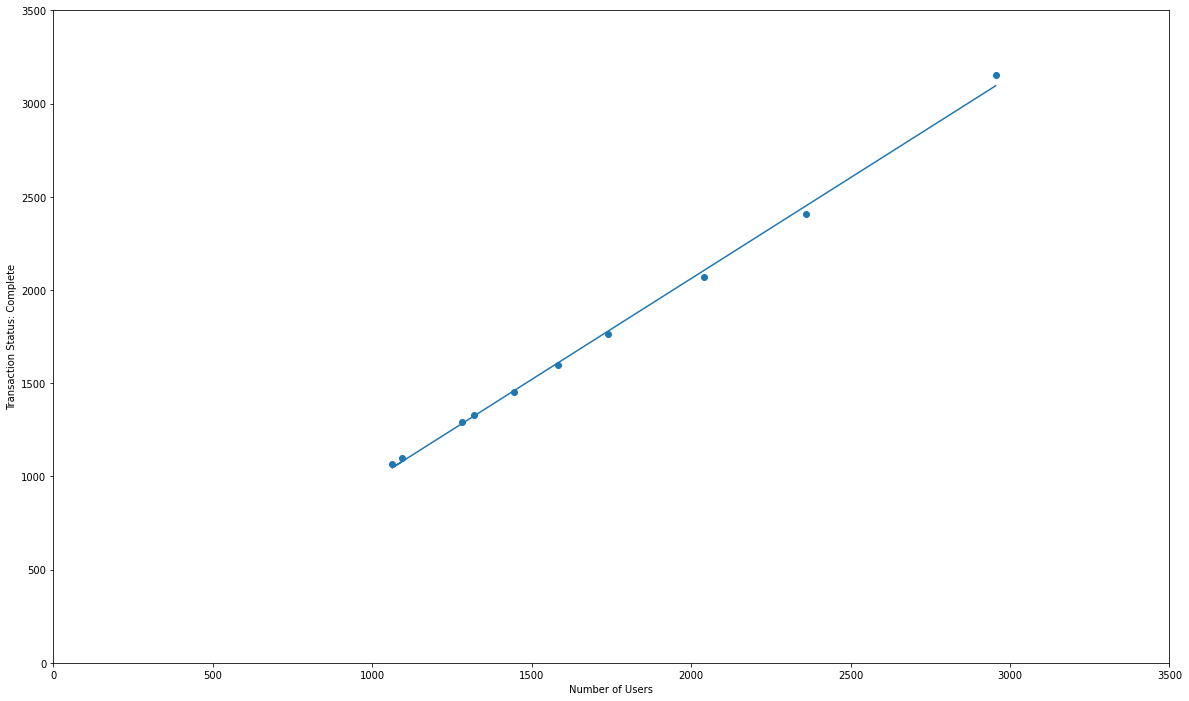

In [ ]:
# Plotting the correlation analysis using pandas between number of users and transaction status complete
x = num_of_users['num_users_complete']
y = transaction_status['status_complete']

slope, intercept, r, p, std_err = stats.linregress(x, y)

def myfunc(x):
 return slope * x + intercept

mymodel = list(map(myfunc, x))
print(mymodel)

plt.figure(figsize=(20,12))
plt.scatter(x, y)
plt.plot(x, mymodel)
plt.ylim(ymin=0, ymax=3500)
plt.xlim(xmin=0, xmax=3500)
plt.xlabel("Number of Users")
plt.ylabel ("Transaction Status: Complete")

plt.show()

[90936.90014297666, 88271.48473289453, 106429.62721407901, 109761.39647668166, 120006.58695918485, 131667.77937829413, 144661.67950244452, 169733.2432035295, 196387.39730435074, 245947.4650855653]


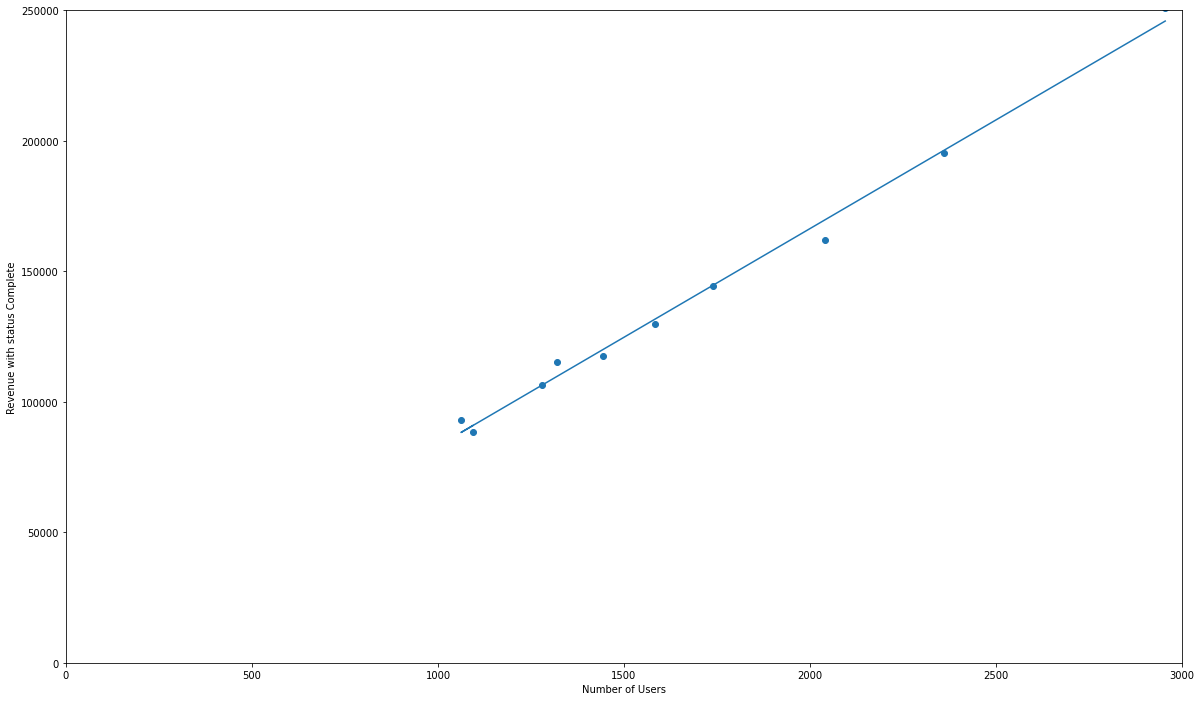

In [ ]:
# Plotting the correlation analysis using pandas between number of users and sum of revenue with status complete
x = num_of_users['num_users_complete']
y = revenue_all['sum_revenue_complete']

slope, intercept, r, p, std_err = stats.linregress(x, y)

def myfunc(x):
 return slope * x + intercept

mymodel = list(map(myfunc, x))
print(mymodel)

plt.figure(figsize=(20,12))
plt.scatter(x, y)
plt.plot(x, mymodel)
plt.ylim(ymin=0, ymax=250000)
plt.xlim(xmin=0, xmax=3000)
plt.xlabel("Number of Users")
plt.ylabel ("Revenue with status Complete")

plt.show()

### **5.2 Gross Merchandise Value (GMV)**

Gross merchandise value (GMV) is the total value of merchandise sold over a given period of time through a customer-to-customer (C2C) exchange site.

```
GMV = Product Sales Price x Number of Products Sold
```

After you calculate GMV and see it increasing it means one of two things:
  1. You’re selling more products, or
  2. You’re selling more expensive products.

It’s best practice to analyze your sales to understand which one is contributing to the increase.

In [ ]:
# GMV Calculation with Complete status transaction
from google.colab import data_table
data_table.enable_dataframe_formatter()
gmv = pd.DataFrame({'Month': ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October"],
                    'Revenues (Complete)': revenue_all['sum_revenue_complete'],
                    'Item Purchased (Complete)': item_purchased['total_item_complete'],
                    'GMV': revenue_all['sum_revenue_complete'] * item_purchased['total_item_complete']})
gmv.round(2)

,Month,Revenues (Complete),Item Purchased (Complete),GMV
0,January,88610.34,1556,1.378777e+08
1,February,93095.27,1527,1.421565e+08
2,March,106587.22,1888,2.012367e+08
3,April,115331.18,1924,2.218972e+08
4,May,117544.55,2041,2.399084e+08
5,June,129754.05,2371,3.076469e+08
6,July,144483.93,2524,3.646774e+08
7,August,162193.73,2946,4.778227e+08
8,September,195195.42,3529,6.888446e+08
9,October,251007.87,4526,1.136062e+09


### **5.3. Business Goals and Solutions**

There are some points that can be taken from the data review and evaluation, which can be useful to answer problems and set the business goals. The focus of this analysis is to solve the problem "*To gain more users, which is to gaining more transactions and revenue*".

**1. Enhancing distribution method in supply chain management**
>Based on the data of `Transaction Status`, the difference between `all status` with `complete status` is relatively huge, especially with status `Shipped`. This can be mean that one of the business goal is **to fix the distribution method in supply chain management**, which is the most important factor to gain more complete transactions.

**2. Database update**
>Only `a quarter` of total number of users registered are actively using The Look e-commerce platform with transaction status `Complete`. Meanwhile the rest of number of users activity are still questionable. Are they still subscribing or actually inactive? Database update is important to make clean up number of users, which will be useful to predict more how many users to gain for the future goals.

**3. Marketing based on Seasonal interest**
>As we can see that there is a potential to gain more profits if the marketing is based on seasonal pattern. For example, `the highest revenue of frequently purchased products` is `Outwears & Coats` which are mostly useful during autumn and winter season. The marketing method can be various, such as using advertisements about The Look platform to provide autumn and winter outfits when the season is cold, or provide more Jeans during hot weather such as summer.

## **6. Conclusion**

As in response of these goals that must be answered:

**1. The data described and explain on part `4. Data Preparation` should answer the main question on Problem Statements.**
> The explanation and description above in Data Preparation mentions that the goals and solutions that can be proposed in order to solve problem statements are:
  - Enhancing distribution method in supply chain management
  - Database update
  - Marketing based on Seasonal interest

**2. To evaluate if the analysis from Q1~Q3 can predict the beginning of Q4 (October), at which the target is $250,000, is realistic.**
> `Total Revenue of Q1~Q3` with status Complete is increasing each month, which is actually a good sign of business health from January to September 2022. `Predicted first month of Q4` which is October 2022, the amount of revenue with `$250,000` is possible to get. Even the revenue based on the calculation in October 2022 is already `$251,007.87`.

**3. To consider whether The Look should get new investors or not during Q4 period (October-December 2022) based on the business health, calculated by Gross Merchandise Value (GMV).**
> Gross Mechnandise Value (GMV) is increasing for the whole year of 2022, it means one of two things: `selling more products (quantity)` or `selling more expensive products (price)`. The Look has a big chance to progress even more to the fourth quarter of 2022 as the patterns is increasing, so it is better to get new investors. This is related to the business goals and solutions: enhancing distribution in supply chain management will be the most important factor to gain more users. Thus, new investors can invest their shares to fix this part of supply chain management, which will mainly improve the service of this C2C platform.